#  Plot comparisons

* Should start to adopt postopus
* Time and N iterations 
* ~Rel density and total density

In [36]:
""" Found with:

import os
from pathlib import Path

notebook_dir = os.path.abspath(os.path.dirname("__file__"))
root = os.path.join(notebook_dir, '..', 'results')

file_list = ["".join(s + '_' for s in filename.split('_')[:-1])[:-1] for filename in os.listdir(Path(root, 'no_preconditioning'))]
file_list = sorted(list(set(file_list)))
print(file_list)
"""

# All systems
all_systems = ['1ALA', '2ALA', '2Dharmonic', '3ALA', '4ALA', 'ASC', 'Cr3', 'Fe_cubic', 'Fe_primitive', 'N_GNF', 'NiO', 'Si', 
               'Si001_1x1_2H', 'TiO2', 'WSe2', 'benzene', 'beta-cyclodextrin', 'betaine', 'methane', 'oxyluciferin', 'polyFePc', 'tetraazacubane']

In [45]:
import os

"""Parser and plotting functions for convergence comparison
"""
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict

%load_ext autoreload
%autoreload 2

from oct_utils import parse_convergence_calculations, initialise_subplot


def parse_wrapper(subdirectories: List[str]) -> Tuple[Dict[str, list], dict]:
    """ Parse data from convergence files into a dictionary.

    Written to work with the plotting in this cell.
    
    Keys are system names and values are lists of dictionaries.
    Each list corresponds to all calculations performed for a given system:
    Specifically 2, one without preconditioning and one with preconditioning.
    As well as data to plot, each dict should contain plotting information (see function body). 

    :param subdirectories: Expect final subdirectories in which the calculations where performed i.e.'1ALA_broyden'
    :return: 
    """
    notebook_dir = os.path.abspath(os.path.dirname("__file__"))
    root = os.path.join(notebook_dir, '..', 'results')

    no_pre_sys_calcs: dict = parse_convergence_calculations([f'{root}/no_preconditioning/{s}' for s in subdirectories])
    pre_sys_calcs: dict = parse_convergence_calculations([f'{root}/preconditioning/{s}' for s in subdirectories])

    # Plot options for no preconditioner and preconditioner calculations, respectively.
    plot_opts1 = {'label': 'No P(r)',
                 'ls': '-',
                 'lw': 2,
                 'color': 'red',
                 }
    plot_opts2 = {'label': 'P(r)',
                 'ls': '--',
                 'lw': 2,
                 'color': 'blue',
                 }

    # Initialise dicts
    name = lambda s: "".join(x + '_' for x in s.split('_')[:-1])[:-1]
    system_calcs = {name(s): [] for s in subdirectories}
    missing_calcs = {'preconditioned': [], 'no preconditioning': []}

    for subdir in subdirectories:
        subnames = Path(subdir).name.split('_')
        mixer = subnames.pop()
        system_name = "".join(s + '_' for s in subnames)[:-1]
        
        try: 
            calculation = no_pre_sys_calcs[system_name]
            calculation.update({'preconditioning': False,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts1
                                })
            system_calcs[system_name].append(calculation)
        except KeyError:
            system_calcs[system_name].append({'preconditioning': False,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts1
                                })
            missing_calcs['no preconditioning'].append(subdir)
            
        try: 
            calculation = pre_sys_calcs[system_name]
            calculation.update({'preconditioning': True,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts2
                               })
            system_calcs[system_name].append(calculation)
        except KeyError:
            system_calcs[system_name].append({'preconditioning': True,
                                'xlabel': 'N SCF Iterations', 
                                'ylabel': 'Relative Change \nin Density (log)', 
                                'plot_options': plot_opts2
                               })
            missing_calcs['preconditioning'].append(subdir)
        
    return system_calcs, missing_calcs


def plot_convergence(systems: List[str], system_calcs: Dict[str, list], n_cols: int, common_settings: dict):
    """Plot kerker convergence against ground state with no preconditioning.
        
    Note, only have access to mixer info if `system_calcs[system_name]` was able to be parsed      

    TODO(Alex) Note, the font sizes etc, should scale with the number of cols per row

    :param systems: 
    :param system_calcs: 
    :param n_cols: 
    :return: 
    """
    n_systems = len(systems)
    n_rows = math.ceil(n_systems/ n_cols)
    fig, axes = initialise_subplot(n_systems, n_cols=n_cols)
    
    # Initialise counters
    empty_lims = 0, 0
    i_cmp = -1
    
    map_index_to_name = {i: name for i, name in enumerate(system_calcs.keys())}
    
    for i, j in itertools.product(range(n_rows), range(n_cols)):
        i_cmp += 1
    
        # Exit when last entry is reached.
        if i_cmp > len(system_calcs) - 1:
            empty_lims = i, j
            break
    
        # All calculations for ith system
        name = map_index_to_name[i_cmp]
        calculations = system_calcs[name]
    
        # Plot calculations for a given system
        for calc in calculations:
            try:
                data = calc.pop('data')
                axes[i, j].plot(data[:, 0], data[:, 1], **calc['plot_options'])
            except KeyError:
                calc_type = 'preconditioning' if calc['preconditioning'] else 'no preconditioning'
                print(f'No data for {name} computed with {calc_type}')
    
        # Scales
        axes[i, j].set_yscale('log')
    
        # Ticks
        axes[i, j].tick_params(axis='both', which='major', labelsize=common_settings['label_size'])
        axes[i, j].tick_params(axis='both', which='minor', labelsize=common_settings['label_size'])
    
        # Labels
        axes[i, j].set_xlabel(calc['xlabel'], fontsize=common_settings['font_size'])
        axes[i, j].set_ylabel(calc['ylabel'], fontsize=common_settings['font_size'])
        axes[i, j].legend(prop={'size': common_settings['legend_fsize']})
        axes[i, j].set_title(f'{name}', fontsize=common_settings['font_size'])
    
    # Remove any empty subplots
    if empty_lims != (0, 0):
        for i, j in itertools.product(range(empty_lims[0], n_rows), range(empty_lims[1], n_cols)):
            axes[i, j].remove()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Missing calculations:
{'preconditioned': [], 'no preconditioning': []}


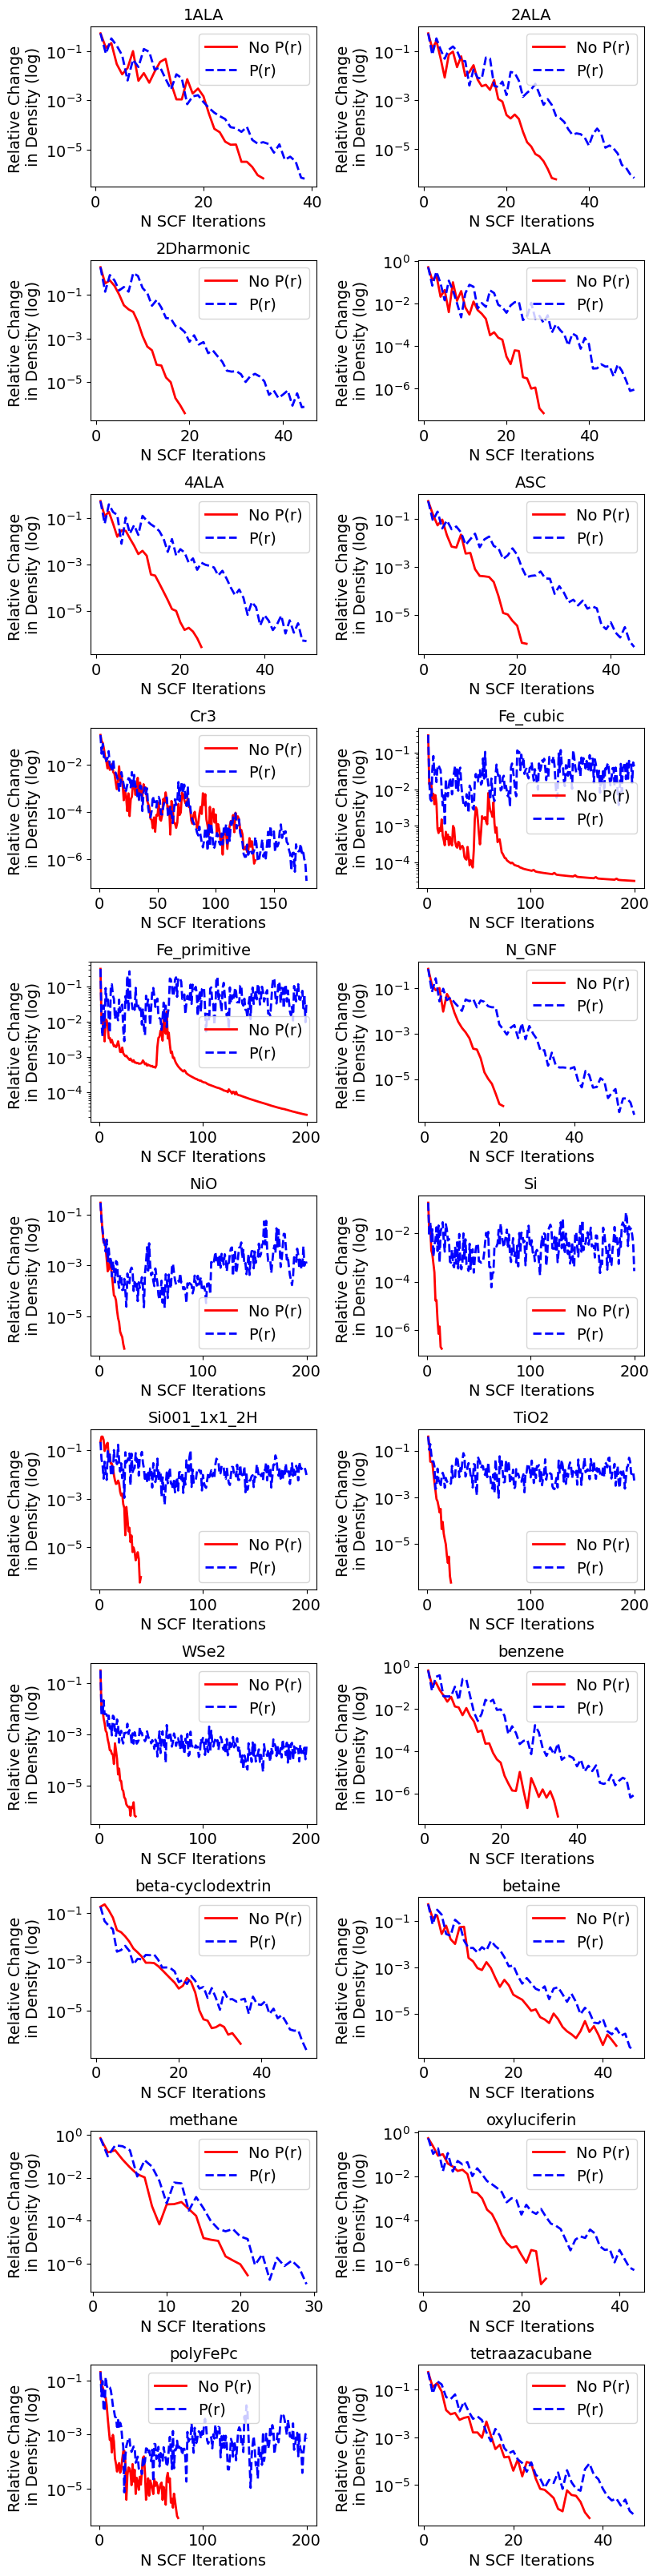

In [48]:
"""SCF Convergence on Benchmark Suite, with and without Preconditioning
"""
test_systems = ['Fe_cubic']
systems = all_systems
mixer = 'broyden'
n_cols = 2
common_settings = {'label_size': 14, 'font_size': 14, 'legend_fsize': 14}

# Parse data
subdirectories = [f'{system}_{mixer}' for system in systems]
system_calcs, missing_calcs = parse_wrapper(subdirectories)

print('Missing calculations:')
print(missing_calcs)

# Plot calculations
plot_convergence(systems, system_calcs, n_cols, common_settings)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


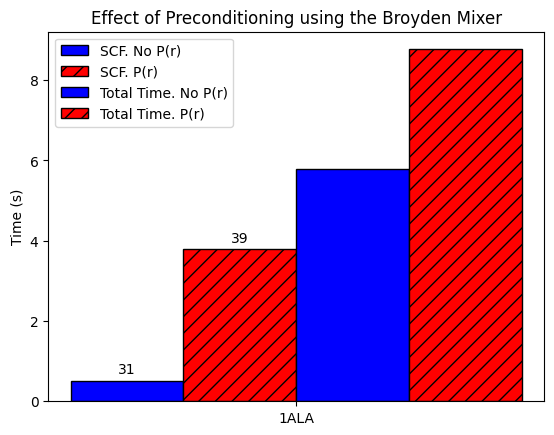

In [10]:
""" Note, it would be worth absorbing these into workflows, which work with Postopus
"""
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from typing import List

from oct_utils import parse_profiling, ConvergenceData


def bar_chart_data_single_field(files, field1: str, field2: str):
    """
    Return a single data field, for all systems
    :param files: 
    :return: 
    """
    values = []
    for file in files:
        data = parse_profiling(file)
        values.append(data['cumulative'][field1][field2])
    return values


def number_of_scf_iterations(files) -> List[int]:
    """ Wrapper util
    :param files: 
    :return: 
    """
    n_scf = []
    for file in files:
        convergence = ConvergenceData(file)
        n_scf.append(convergence.n_scf_iterations())
    return n_scf
    

def bar_plot(systems: List[str], fields: List[dict], width = 0.27, bar_labels=None, title=''):
    """ Plot several bar plots (one per field) for each system
    
    Adapted from this reference:
    https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
    
    :param systems: 
    :param fields: 
    :param width: 
    :return: 
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_dummy = np.arange(len(systems))  # the x locations for the systems
    ax.set_title(title)
    
    plots = []
    field_labels = []
    for i, field in enumerate(fields):
        data = field.pop('data')
        label = field.pop('label')
        # Plot a bar chart for single field, for all systems
        plot = ax.bar(x_dummy + (i * width), data, width, **field)
        plots.append(plot)
        field_labels.append(label)

    ax.set_ylabel('Time (s)')
    ax.set_xticks(x_dummy + ((len(fields) - 1) * 0.5 * width))
    ax.set_xticklabels(systems)
    ax.legend(plots, field_labels)

    if bar_labels is None:
        return
    
    # Add N SCF iterations as labels. Want plots 0 and 1
    for labels_for_field in bar_labels:
        ifield = labels_for_field['field']
        labels = labels_for_field['labels']
        assert len(labels) == len(systems)
        # For a given field, loop over each bar of the plot
        # i.e iterate over all systems contributing data to this field
        for i, bar in enumerate(plots[ifield]):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, labels[i], ha='center', va='bottom')


# SCF Time - no preconditioner
files = ['no_preconditioning/1ALA_broyden']
scf_no_pre_values = bar_chart_data_single_field(files, 'SCF_CYCLE', 'TOTAL_TIME')
# Total time - no preconditioner
total_no_pre_values = bar_chart_data_single_field(files, 'COMPLETE_RUN', 'TOTAL_TIME')
# Number of SCF iterations
nscf_no_pre = number_of_scf_iterations(files)

# SCF Time - Preconditioner
files = ['preconditioning/1ALA_broyden']
scf_pre_values = bar_chart_data_single_field(files, 'SCF_CYCLE', 'TOTAL_TIME')
# Total time - Preconditioner
total_pre_values = bar_chart_data_single_field(files, 'COMPLETE_RUN', 'TOTAL_TIME')
# Number of SCF iterations
nscf_pre = number_of_scf_iterations(files)


fields = [{'data': scf_no_pre_values, 'label': 'SCF. No P(r)', 'color': 'b', 'hatch': '', 'edgecolor': 'black'},
          {'data': scf_pre_values, 'label': 'SCF. P(r)', 'color': 'r', 'hatch': '//', 'edgecolor': 'black'},
          {'data': total_no_pre_values, 'label': 'Total Time. No P(r)', 'color': 'b', 'hatch': '', 'edgecolor': 'black'},
          {'data': total_pre_values, 'label': 'Total Time. P(r)', 'color': 'r', 'hatch': '//', 'edgecolor': 'black'}]


# Apply labels to bars, for the SCF fields
# where the field index is defined by the order in fields, above
bar_labels = [{'field': 0, 'labels': nscf_no_pre}, {'field': 1, 'labels': nscf_pre}]

systems = ['1ALA']
title = 'Effect of Preconditioning using the Broyden Mixer'
bar_plot(systems, fields, bar_labels=bar_labels, title=title)




In [2]:
""" Timings in Table Form

More stats of interest:
* | N SCF steps with P(r) | Converged with P(r) | N SCF steps without P(r) | Converged w/o P(r)
"""
import numpy as np
import pandas as pd

# 'cumulative' or 'self'
time_type = 'cumulative'
# Subdirectory names for calculations
systems = ['1ALA_broyden']

# Create List[dict] for pandas
entries = []
stats = {'scf w': [], 'scf w/o': []}

for system in systems:
    system_name, mixer = system.split('_')
    data_to_visualise = {'System': system_name, 'Mixer': mixer}
    
    data_no_pre = parse_profiling(f'no_preconditioning/{system}')[time_type]
    data_pre = parse_profiling(f'preconditioning/{system}')[time_type]
    
    # TODO(Alex) Add n-atoms
    data_to_visualise.update({'SCF time w/o P(r)':   data_no_pre['SCF_CYCLE']['TOTAL_TIME'],
                              'SCF time w P(r)':      data_pre['SCF_CYCLE']['TOTAL_TIME'],
                              'Total time w/o P(r)': data_no_pre['COMPLETE_RUN']['TOTAL_TIME'],
                              'Total time w P(r)':    data_pre['COMPLETE_RUN']['TOTAL_TIME'],
                              'SCF Faster with P(r)?': data_no_pre['SCF_CYCLE']['TOTAL_TIME'] > data_pre['SCF_CYCLE']['TOTAL_TIME']}
                             )
    entries.append(data_to_visualise)
    
    # Collect some data for stats
    stats['scf w/o'].append(data_no_pre['SCF_CYCLE']['TOTAL_TIME'])
    stats['scf w'].append(data_pre['SCF_CYCLE']['TOTAL_TIME'])

pd.set_option('display.width', 120)  # Set the overall display width w.r.t. n_characters
df = pd.DataFrame(entries)
print(df)
print()

# Compute some stats
print('Summary')
print('--------------')

n_entries = len(df)
speed_up = np.empty(shape=n_entries)
for i in range(n_entries):
    speed_up[i] = stats['scf w/o'][i] / stats['scf w'][i]

# Percentage that are slower, and by how much
slower = speed_up[speed_up < 1.]
if len(slower) == 0:
    print(f'{len(slower)} / {n_entries} have slower SCF time')
else:
    print(f'{len(slower)} / {n_entries} have slower SCF time, by an average of {np.mean(1. / slower)} x')

# Percentage that are faster, and by how much
faster = speed_up[speed_up >= 1.]
if len(faster) == 0:
    print(f'{len(faster)} / {n_entries} have faster SCF time')
else:
    print(f'{len(faster)} / {n_entries} have faster SCF time, by an average of {np.mean(faster)} x')





  System    Mixer  SCF time w/o P(r)  SCF time w P(r)  Total time w/o P(r)  Total time w P(r)  SCF Faster with P(r)?
0   1ALA  broyden           0.509039         3.794614             5.794115           8.767568                  False

Summary
--------------
1 / 1 have slower SCF time, by an average of 7.4544661607460325 x
0 / 1 have faster SCF time
